**Recommender system - personalized content-based module:**<br>

With user ID and restaurant’s metadata and restaurant reviews, build a content based filtering recommender module that recommends restaurants that are similar to user’s preference inferred from user’s past ratings. More specifically, pairwise similarity scores will be computed for restaurants based on their vectorized feature representation extracted using CountVectorizer or TfidfVectorizer and recommend restaurants based on rankings of the weighted similarity score (e.g. cosine similarity). The important restaurant metadata to consider include categories, attributes, location.<br>

**Metrics chosen for evaluating the cosine-similarity ranking:**<br>
NDCG (Normalized Discounted Cumulative Gain), which works well with relevance scores in the form of real numbers (binary, integar or float), in this case, review ratings of 1-5, is chosen over MAP (Mean average precision), which assumes only binary relevance (interesting or not, click or not). 

**Note:**<br> 
Only a subset of Yelp restaurants from a few selected states are available in this dataset. Among them, only Arizona, Nevada, Ohio, North Carolina and Pennsylvania have a rich catalog of over 5000 restaurants. 
Only the top two states, Arizona and Nevada have over 10000 restaurants. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

business = pd.read_csv('business_clean.csv')  # contains business data including location data, attributes and categories
#user = pd.read_csv('user_clean.csv') # contains users data including the user's friend mapping and all the metadata associated with the user
review = pd.read_csv('review_clean.csv') # contains full review text data including the user_id that wrote the review and the business_id the review is written for
#tip = pd.read_csv('tip_clean.csv') # tips written by a user on a business, tips are shorter than reviews and tend to convey quick suggestions
#checkin = pd.read_csv('checkin_clean.csv') # checkins on a business

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 1. Adjusted rating

Here, a single metric is introduced as a substitute of the original average restaurant rating ('stars' column of the business dataframe). Ideally, the new metric should take into consideration: <br>
1) average rating of the restaurant (indicates the goodness of the restaurant, but does not consider popularity) <br>
2) # of ratings by users (indicates popularity, but does not imply the goodness of the restaurant) <br>
3) age of the rating (indicates the relevance of the rating, as outdated ratings might fail to indicate the actual quality)<br>

The proposed new score is: 
$$score_i = \frac{\sum_u r_{ui} + k*\mu}{n_i+k}$$

where $r_ui$ is the rating on item i by user u, $n_i$ is the number of rating on item i, $\mu$ is the global mean of ratings over all businesses and all users and k is the strength of the damping term.

As the equation shows, the adjusted score uses the mechanism of the damped mean to regulate the extreme cases of having only a few extreme ratings. k controls the strength of the damping effect: the larger k is, the more actual ratings are required to overcome the global mean.

In this case, k is set to 4 (which is the 10% quantile of the review counts for all businesses), but it can be tuned according to various business considerations.  

Note:<br> 
Here, the age of the rating is not adjusted in the current version of the proposed metric. This is because 90% of the reviews/ratings are from year 2011 and later, and are considered quite relevant. Therefore, the need of adjusting for the age of the ratings is not strong.

In [2]:
# compute globe mean ratings of all businesses and all reviews
globe_mean = ((business.stars * business.review_count).sum())/(business.review_count.sum())
print("global mean rating is:", globe_mean)

global mean rating is: 3.7277814701620127


In [3]:
print(business.review_count.quantile([0.1,0.25,0.5,0.75,0.9]))
k = 22 # set strength k to 22, which is the 50% quantile of the review counts for all businesses
business['adjusted_score'] = (business.review_count * business.stars + k * globe_mean)/(business.review_count + k)
print("\nrank by the adjusted score in descending order:")
print(business[['review_count','stars','adjusted_score']].sort_values('adjusted_score', ascending=False).head(5))
print("\nrank by the original score in descending order:")
print(business[['review_count','stars','adjusted_score']].sort_values('stars', ascending=False).head(5))
print("\nrank by the least number of reviews:")
print(business[['review_count','stars','adjusted_score']].sort_values('review_count', ascending=True).head(5))

0.10      4.0
0.25      8.0
0.50     22.0
0.75     66.0
0.90    172.0
Name: review_count, dtype: float64

rank by the adjusted score in descending order:
       review_count  stars  adjusted_score
7464           1746    5.0        4.984169
31910          1380    5.0        4.980037
45401           547    5.0        4.950811
7784            520    5.0        4.948360
28162           472    5.0        4.943342

rank by the original score in descending order:
       review_count  stars  adjusted_score
22115             7    5.0        4.034869
23114             5    5.0        3.963377
42990             5    5.0        3.963377
42989            16    5.0        4.263452
12778             3    5.0        3.880448

rank by the least number of reviews:
       review_count  stars  adjusted_score
0                 3    4.5        3.820448
5707              3    4.0        3.760448
16594             3    4.0        3.760448
5699              3    3.5        3.700448
16605             3    3.5  

# 2. Train-test-split

## 2.1 extract subset of 'review' dataframe for reviews related to restaurant businesses

In [4]:
%%time

# extract a subset of reviews related to the restaurant business of our interest
review_s = review[review.business_id.isin(business.business_id.unique())].reset_index(drop=True)
print(len(review), len(review_s))

5996995 3469589
CPU times: user 4.3 s, sys: 12.5 s, total: 16.8 s
Wall time: 23.3 s


note: this reduces the number of the review records in the 'review' dataframe from 5,996,995 down to 3,469,589. 

## 2.2 Initialize with a random train-test-split

In [5]:
%%time

# shuffle the index of review_s for random split
np.random.seed(42)
idx = np.array(review_s.index, dtype='int')
np.random.shuffle(idx)

# start with a train-test-split by 87%-13% ratio
train = review_s.loc[idx[:int(0.87*len(idx))]]
test = review_s.loc[idx[int(0.87*len(idx)):]]

CPU times: user 6.03 s, sys: 6.48 s, total: 12.5 s
Wall time: 15.7 s


In [6]:
len(train)/len(test)

6.692300358942638

## 2.3 Move reviews of user_id that only exists in testset back to trainset

In [7]:
%%time
# add one review of user_id that only exists in testset back to trainset

# determine the idx to move from testset to trainset
user_test_only = test[~test.user_id.isin(train.user_id.unique())] # filter testset to reviews by user_id only exists in the testset
user_idx_toadd = user_test_only['user_id'].drop_duplicates().index # extract the index of the reviews to add back to the trainset

# update the new list of indices for the trainset and testset
idx_train = train.index.union(user_idx_toadd)
idx_test = review_s.index.difference(idx_train)

# update trainset and testset
train = review_s.loc[idx_train]
test = review_s.loc[idx_test]

CPU times: user 5.52 s, sys: 10.1 s, total: 15.7 s
Wall time: 20.1 s


In [8]:
len(train)/len(test)

8.206157446593982

## 2.4 Move reviews of business_id that only exists in testset back to trainset

In [9]:
%%time
# add at least one review of business_id that only exists in testset back to trainset

# determine the idx to move from testset to trainset
rest_test_only = test[~test.business_id.isin(train.business_id.unique())] # filter testset to reviews by user_id only exists in the testset
rest_idx_toadd = rest_test_only['business_id'].drop_duplicates().index # extract the index of the reviews to add back to the trainset

# update the new list of indices for the trainset and testset
idx_train = train.index.union(rest_idx_toadd)
idx_test = review_s.index.difference(idx_train)

# update trainset and testset
train = review_s.loc[idx_train]
test = review_s.loc[idx_test]

CPU times: user 3.72 s, sys: 8.06 s, total: 11.8 s
Wall time: 15.6 s


In [10]:
assert (len(train) + len(test)) == len(review_s)
# calculate train vs test sample ratio
print('final train/test ratio:', len(train)/len(test))

final train/test ratio: 8.20627958564181


As shown, the final trainset vs. testset ratio is 8.2063, corresponding to a 89%-11% train-set split. 

# 3. Building restaurant feature space from restaurant reviews

## 3.1 combine reviews for each restaurants

In [11]:
%%time

# groupby business_id and concatenate all reviews of the same business together, reviews are separated by '###'
rev_by_rest = train.groupby('business_id').agg({'review_id': 'count', 'text': lambda i: '###'.join(i)}).rename(columns={'review_id':'review_count','text':'review_combined'})
rev_by_rest = rev_by_rest.reset_index()

CPU times: user 9.85 s, sys: 35.1 s, total: 44.9 s
Wall time: 1min 16s


In [12]:
# %%time
# this is for training on the entire 'review_s' dataset
# # groupby business_id and concatenate all reviews of the same business together, reviews are separated by '###'
# rev_by_rest = review_s.groupby('business_id').agg({'review_id': 'count', 'text': lambda i: '###'.join(i)}).rename(columns={'review_id':'review_count','text':'review_combined'})
# rev_by_rest = rev_by_rest.reset_index()

In [13]:
print(rev_by_rest.info())
print(rev_by_rest.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47553 entries, 0 to 47552
Data columns (total 3 columns):
business_id        47553 non-null object
review_count       47553 non-null int64
review_combined    47553 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
              business_id  review_count  \
0  --7zmmkVg-IMGaXbuVd0SQ            47   

                                     review_combined  
0  Great beer, great place, excellent service fro...  


## 3.2 Tfidf to extract top features from reviews

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [15]:
%%time

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000) # limit to top 1000 words
X = vectorizer.fit_transform(rev_by_rest.review_combined)
print(vectorizer.get_feature_names()[:50])
print(X.shape)

['00', '10', '10 minutes', '100', '11', '12', '15', '15 minutes', '20', '20 minutes', '25', '30', '30 minutes', '40', '45', '50', '99', 'able', 'absolutely', 'actually', 'add', 'added', 'addition', 'afternoon', 'ago', 'ahead', 'airport', 'amazing', 'ambiance', 'american', 'apparently', 'appetizer', 'appetizers', 'area', 'aren', 'arrived', 'asada', 'asian', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado']
(47553, 1000)
CPU times: user 8min 43s, sys: 51.9 s, total: 9min 35s
Wall time: 10min 8s


In [16]:
rest_revfeature = pd.SparseDataFrame(X)
rest_revfeature = rest_revfeature.set_index(rev_by_rest.business_id)
rest_revfeature.columns = vectorizer.get_feature_names()
rest_revfeature = rest_revfeature.fillna(0) # fill in missing values with 0 to use PCA

In [17]:
# look at the bigrams being picked up in the top 1000 features
for i in rest_revfeature.columns:
    if len(i.split())>1:
        print(i)

10 minutes
15 minutes
20 minutes
30 minutes
best ve
customer service
definitely recommend
don know
don think
fast food
feel like
felt like
food amazing
food came
food delicious
food good
food great
food just
food service
fried chicken
fried rice
friendly staff
good food
good place
good service
great food
great place
great service
happy hour
highly recommend
ice cream
just right
las vegas
little bit
long time
looked like
love place
mac cheese
make sure
mexican food
place great
pretty good
quality food
really enjoyed
really good
really nice
recommend place
right away
service excellent
service food
service good
service great
staff friendly
super friendly
tasted like
try place
ve tried
wait staff


## 3.3 feature reduction with PCA

In [18]:
# feature selection
from sklearn.decomposition import PCA

pca = PCA()
rest_pcafeature = pca.fit_transform(rest_revfeature)
vr = pca.explained_variance_ratio_

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


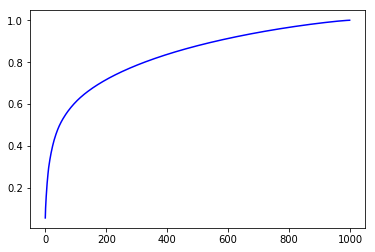

In [19]:
# compute cumulative explained variance ratio
vr_cum = [sum(vr[:i+1]) for i in range(len(vr))]
# plot explained variance ratio vs the number of PCA components
plt.plot(list(range(len(vr))),vr_cum, color='blue'); 

As shown, the first 300 PCA components are responsible for the 80% of the variation. Therefore, the first 300 components will be kept as the restaurant features and the rest less relevant components will be dropped. 

In [20]:
# extract all PCA components 
components = pd.DataFrame(data=pca.components_, columns = rest_revfeature.columns)

# inspect the top 10 PCA components, in relationship to the original review features
for i in range(10):
    component = components.loc[i].sort_values(ascending=False)
    print("principle component #{}:\n".format(i), component[:5])

principle component #0:
 pizza       0.750790
crust       0.106085
pizzas      0.081179
delivery    0.077048
toppings    0.045206
Name: 0, dtype: float64
principle component #1:
 pizza      0.537485
food       0.374550
good       0.184521
chicken    0.169766
ordered    0.134355
Name: 1, dtype: float64
principle component #2:
 bar       0.439833
beer      0.216703
great     0.168844
drinks    0.168225
night     0.152813
Name: 2, dtype: float64
principle component #3:
 coffee       0.343310
sandwich     0.255072
order        0.199278
breakfast    0.185238
location     0.178457
Name: 3, dtype: float64
principle component #4:
 hotel    0.384352
room     0.335998
rooms    0.193565
stay     0.182034
desk     0.155869
Name: 4, dtype: float64
principle component #5:
 tacos      0.350580
mexican    0.284093
taco       0.267722
burrito    0.220602
salsa      0.211116
Name: 5, dtype: float64
principle component #6:
 coffee       0.498896
breakfast    0.237049
mexican      0.193652
tacos        0.

In [21]:
rest_pcafeature = pd.DataFrame(rest_pcafeature[:,:300], index=rest_revfeature.index, columns=[str(i) for i in np.arange(1,301)])
rest_pcafeature.columns.name = 'pca_components'

In [22]:
# rescale rest_pcafeature coefficients so all restaurant feature vectors share the same unit length of 1
rest_pcafeature['root_squared_sum'] = rest_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
rest_pcafeature = rest_pcafeature.drop('root_squared_sum',axis=1).divide(rest_pcafeature.root_squared_sum, axis=0)

In [23]:
rest_pcafeature.head(2)

pca_components,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
business_id,,,,,,,,,,,,,,,,,,,,,
--7zmmkVg-IMGaXbuVd0SQ,-0.059117,-0.105398,0.422339,-0.163535,-0.150402,0.154040,-0.049404,-0.074484,-0.119477,-0.036121,...,0.001167,0.012947,-0.003036,0.007732,0.030837,0.013390,0.017888,0.001863,0.008954,-0.018501
--9e1ONYQuAa-CB_Rrw7Tw,-0.253481,0.189959,0.154282,-0.046448,-0.096910,-0.162727,0.100155,0.234075,0.187176,0.115527,...,0.008941,0.002228,0.016030,-0.005315,-0.000960,0.005053,-0.014484,0.009511,-0.013295,-0.006675


## 3.4 compute user feature vector

In [24]:
%%time

# build user preference profile by compute a weighted sum of the restaurant vectors for all rated items by the user, with weights being the user’s rating
user_pcafeature = pd.merge(train[['user_id','business_id','stars']], rest_pcafeature, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)

CPU times: user 9.87 s, sys: 18.3 s, total: 28.2 s
Wall time: 39 s


In [25]:
# %%time
# this is for training on entire 'review_s' dataset
# # build user preference profile by compute a weighted sum of the restaurant vectors for all rated items by the user, with weights being the user’s rating
# user_pcafeature = pd.merge(review_s[['user_id','business_id','stars']], rest_pcafeature, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)

In [26]:
%%time

# rescale component coefficients by the review rating as the correpsonding weight
user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(user_pcafeature.stars, axis=0)

CPU times: user 18.4 s, sys: 57.3 s, total: 1min 15s
Wall time: 1min 41s


In [27]:
%%time

# sum up all component coefficients by user_id
user_pcafeature = user_pcafeature.drop('stars', axis=1).groupby('user_id').sum()
user_pcafeature.head(2)

CPU times: user 50.4 s, sys: 3min 52s, total: 4min 43s
Wall time: 12min 5s


In [28]:
%%time

# rescale user_pcafeature coefficients so all user feature vectors share the same unit length of 1
user_pcafeature['root_squared_sum'] = user_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_pcafeature = user_pcafeature.drop('root_squared_sum', axis=1).divide(user_pcafeature.root_squared_sum, axis=0)

CPU times: user 53.3 s, sys: 20.8 s, total: 1min 14s
Wall time: 1min 34s


In [29]:
user_pcafeature.head(2)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,-0.127453,0.277403,0.20038,-0.093381,-0.248164,-0.077411,0.217152,0.257582,0.218357,0.167718,...,0.006834,0.006594,-0.020860,-0.001917,0.010947,0.012562,0.009829,-0.006487,0.009611,-0.020761
---89pEy_h9PvHwcHNbpyg,-0.282799,0.142310,0.55229,-0.139603,-0.098204,0.213660,-0.045450,-0.170433,-0.015855,-0.057000,...,-0.006070,0.022393,-0.009297,0.005656,0.003809,-0.010870,0.028299,-0.009836,-0.010688,-0.014143


### Discussions on the weights to use for aggregating users' preference from review ratings: 

As shown above, the weights used here for aggregating users' preference is simply the star ratings the users gave along with the reviews. This does not take into consideration that different users might have different rating criteria and scale, some are more generous and some are more critical. <br>
But as discussed below, this is considered a simple and more effective approach than other alternatives in this case.

In [30]:
# # Alternative #1: use user's review rating of a restaurant minus 3 (the median of a 1-5 star rating system) as the weight of that restaurant
# # when computing user feature vector from the weighted sum of restaurant vectors

# # rescale component coefficients by the review rating as the correpsonding weight
# user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(user_pcafeature.stars-3, axis=0)

Note: alternative \#1 is very similar to the simple star rating as the weights, except that it offsets the weight from positive scale of 1 to 5 to a scale of -2 to 2. Therefore, it does not take into consideration that different users might have different rating criteria and scale either. In addition, the preference indicated by review ratings of 3 is lost because those weights will become 0. Therefore, this alternative method of modifying weights is not adopted here.

In [31]:
# # Alternative #2: use user's review rating of a restaurant minus the mean rating of the user as the weight of that restaurant
# # when computing user feature vector from the weighted sum of restaurant vectors

# # compute mean ratings by user
# user_mean_rating = train.groupby('user_id').stars.mean().rename(columns={'stars':'user_mean_rating'})
# user_pcafeature = pd.merge(user_pcafeature, user_mean_rating, how='inner', left_on='user_id', right_index=True)
# weights = user_pcafeature.stars - user_pcafeature.user_mean_rating

# # rescale component coefficients by the review rating as the correpsonding weight
# user_pcafeature.loc[:, '1':'300'] = user_pcafeature.loc[:,'1':'300'].multiply(weights, axis=0)

# # sum up all component coefficients by user_id
# user_pcafeature = user_pcafeature.drop(['stars','user_mean_rating'], axis=1).groupby('user_id').sum()
# user_pcafeature.head(2)

# # rescale user_pcafeature coefficients so all user feature vectors share the same unit length of 1
# user_pcafeature['root_squared_sum'] = user_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
# user_pcafeature = user_pcafeature.drop('root_squared_sum', axis=1).divide(user_pcafeature.root_squared_sum, axis=0)

Note: although alternative method \#2 of adjusting the weights takes into consideration that different users might have different rating criteria and scale, some are more generous and some are more critical, it causes potential problems as well: <br>
1) some Yelp users only go to Yelp to review restaurants when they have really positive experiences. By substracting the user's mean rating, this strong preference is arbituarily removed.<br>
2) similar to 1), some users only reviews when they have really negative experiences, this strong dislikes will be removed by substracting the user mean as well.<br>
3) there are a substaintial amount of users (547,561 users) in the 'review' dataset that only has one review/rating in total, these users' preference will be lost since substracting user mean will result in zero weights.<br> 
Therefore, this alternative method of adjusting weights is not used in this project. 

## 3.5 Save restaurant pca features and user pca features to file
Re-train on entire 'review_s' dataframe instead of just the trainset and save the restaurant feature vectors and user feature vectors to file. 

Note:<br> 
the feature vectors from training on the trainset are saved to 'rest_pcafeature.pkl' and 'user_pcafeature.pkl';<br>
the feature vectors from re-training on the entire restaurant review dataset are saved to 'rest_pcafeature_allset.pkl' and 'user_pcafeature_allset.pkl'.

In [32]:
import pickle

In [33]:
%%time

# save rest_pcafeature as pickled file
with open('rest_pcafeature.pkl','wb') as f:
    pickle.dump(rest_pcafeature, f)

CPU times: user 157 ms, sys: 749 ms, total: 905 ms
Wall time: 1.78 s


In [34]:
%%time

# save user_pcafeature as pickled file, note: need to write in chucks of size smaller than 2GB due to a bug in Python3
max_bytes = 2**31 - 1
bytes_out = pickle.dumps(user_pcafeature)
with open('user_pcafeature.pkl','wb') as f:
    for idx in range(0, len(bytes_out), max_bytes):
        f.write(bytes_out[idx:idx+max_bytes])

CPU times: user 5.06 s, sys: 19.6 s, total: 24.6 s
Wall time: 50.2 s


# 4. Building restaurant feature space from restaurant metadata

In [35]:
business.info()

# value in feature space should all be numerical

# 1. extract useful attributes
# 2. extract hours, day of the week (coded 1-7)
# 3. parse useful information from business name
# 4. cuisine, style
# category
# concatenate all features together and user countvectorizer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47553 entries, 0 to 47552
Data columns (total 64 columns):
attributes.WheelchairAccessible          20673 non-null object
hours.Tuesday                            33717 non-null object
attributes.BYOBCorkage                   1400 non-null object
hours.Monday                             31888 non-null object
attributes.AcceptsInsurance              3 non-null object
hours.Thursday                           34332 non-null object
attributes.HappyHour                     6318 non-null object
address                                  46660 non-null object
business_id                              47553 non-null object
attributes.DietaryRestrictions           92 non-null object
hours.Saturday                           33671 non-null object
postal_code                              47553 non-null int64
attributes.GoodForMeal                   29367 non-null object
attributes.Alcohol                       30071 non-null object
attributes.HairSpec

In [36]:
rest_metafeature = business[['business_id','address','postal_code','city','state','name','neighborhood']].set_index('business_id')

In [37]:
rest_metafeature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47553 entries, AjEbIBw6ZFfln7ePHha9PA to 3_fIsSxN2RBovQ_6EFtLzA
Data columns (total 6 columns):
address         46660 non-null object
postal_code     47553 non-null int64
city            47553 non-null object
state           47553 non-null object
name            47553 non-null object
neighborhood    15832 non-null object
dtypes: int64(1), object(5)
memory usage: 2.5+ MB


# 5. Evaluate the cosine-similarity ranking

## 5.1 Ranking metrics

NDCG (Normalized Discounted Cumulative Gain), which works well in this case with review ratings of 1 to 5, is chosen over MAP (Mean average precision), which only assumes binary relevance (interesting or not, click or not).

DCG(Discounted Cumulative Gain) is calculated as the sum of the gain (relevance score) of item at each position in the ranking list, discounted by their position i. 
$$DCG(Rank)=∑_iu_i * d_i$$
where $u_i$ is the gain of item at ranking position $i$, and $d_i$ is the discount of item at ranking position $i$. 
The discount $d$ is a function that decreases with position further down the list:
$$d_i=\frac{1}{log_2(i+1)}$$

NDCG is calculated as the actual DCG normalized by maximum achievable DCG (a perfect ranking in the descreasing order of the relevance score) 
$$nDCG(Rank)=\frac{DCG(Rank)}{DCG(Perfect Rank)}$$

Note: nDCG is increasingly popular, as it works well with a variety type of relevance scores, binary, integar or float numbers.

In [38]:
# function for computing normalized Discounted Cumulative Gain as the ranking metric
# inspired by https://gist.github.com/bwhite/3726239

def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values, in this case, the review rating ranging 1-5. 
    Discount starts to take effect from the second item in the list, with the weights being 1/log2(rank position+1)
    (Weights being [1.0, 0.6309, 0.5, 0.4307, 0.3869, ...] for the first items in the rank)
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    ---
    Args:
        r: a list or numpy 1D array of relevance scores corresponding to the rank order
        k: Number of results to consider (consider only top-k)
    ---
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:min(len(r),k)]  # convert to float-type numpy array and extract only top-k
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return None

def ndcg_at_k(r, k):
    """Score is normalized discounted cumulative gain (ndcg), normalized by the maximum achievable DCG (Discounted Cumulative Gain)
    ---
    Args:
        Same as dcg_at_k(r,k)
    ---
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k) # compute the maximum achievable DCG based on the perfect ranking
    dcg = dcg_at_k(r, k) # compute the actual DCG based on the actual ranking
    if dcg_max == None or dcg == None:
        return None
    return dcg/dcg_max

## 5.2 Compute & evaluate rankings based on cosine similarity from review-based pca features

Since the restaurant pcafeature vectors and the user pcafeature vectors all have a unit length of 1, linear_kernel from sklearn.metrics.pairwise is used instead of cosine_similarity to speed up the calculation. 

In [39]:
from sklearn.metrics.pairwise import linear_kernel

In [40]:
%%time
# look at a particular user_id as an example

user_id = '---1lKK3aKOuomHnwAkAow' # 11 review ratings available in the testset

# compute user-restaurant similarity
sim_matrix = linear_kernel(user_pcafeature.loc[user_id].values.reshape(1, -1), rest_pcafeature)
sim_matrix = sim_matrix.flatten()
sim_matrix = pd.Series(sim_matrix, index = rest_pcafeature.index).sort_values(ascending=False)
sim_matrix.name = 'similarity_score'

# look at similarity score for reviews/ratings in the testset by the user of interest
rec = pd.concat([sim_matrix, test[test.user_id == user_id].set_index('business_id').stars], axis=1, join='inner')
print('Ranking by cosine similarity score:\n', rec)
ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by cosine similarity score:
                         similarity_score  stars
business_id                                    
YCEZLECK9IToE8Mysorbhw          0.329092      5
AZlnpvILz5cEWJifjr2CSQ          0.324308      5
_sh6mIBWZis66mAjkjN8Qg          0.238217      5
x-80R4DE6AsYoDtA2H-sKw          0.208107      3
2BbFeotL85cIaBjSq1SWiA          0.204794      1
TTpgjbrSyxwHHzE5bIF-Rw          0.192319      3
UutHMmZx1CQcjiyfmVa_7g          0.130481      5
CeqWpwHBoaxwRcv5btnv6g          0.123849      5
DV13F0bhe55dV1AhwoO50g          0.115896      5
rq5dgoksPHkJwJNQKlGQ7w          0.096958      5
RJtgNpUFthlJ5grLr16GxA          0.025944      5

Normalized discounted cumulative gain achieved at top-10 based on testset:
 0.9098790747203894
CPU times: user 765 ms, sys: 648 ms, total: 1.41 s
Wall time: 1.89 s


In [41]:
%%time
# evaluate NDCG@top10 on the entire testset

# only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
rev_count_by_user = test.groupby('user_id').review_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

ndcg_scores = []
# compute NDCG score for each user in the testset
for user_id in user_id_of_interest: 
    
    # compute user-restaurant similarity matrix for the user of interest
    sim_matrix = linear_kernel(user_pcafeature.loc[user_id].values.reshape(1, -1), rest_pcafeature)
    sim_matrix = sim_matrix.flatten() # flatten the similarity matrix for a particular user into 1D array
    sim_matrix = pd.Series(sim_matrix, index = rest_pcafeature.index).sort_values(ascending=False)
    sim_matrix.name = 'similarity_score'

    # look at similarity score for reviews/ratings in the testset by the user of interest
    rec = pd.concat([sim_matrix, test[test.user_id == user_id].set_index('business_id').stars], axis=1, join='inner')
    assert len(rec) >= 10
    ndcg = ndcg_at_k(r=rec.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores.append(ndcg)
    
    if ndcg < 0.5: # if low ndcg score below 0.5, print the ranking results
        print('Ranking by cosine similarity score for user_id of {} is:\n {}'.format(user_id, rec.head(10)))

Ranking by cosine similarity score for user_id of EgUGBGTJUvFJgHyFwgpD1w is:
                         similarity_score  stars
business_id                                    
0fW77t7I2673JY27JWC-yw          0.542322      2
nUfeYJ_YEaDzggPKnYry3g          0.537483      1
cTJjTKz2huGZ-ElScC2pSw          0.516030      2
UlSvQqRRzrqRy5i5hHlQaA          0.466036      1
16d3BlncEyCTzb0GxXrBXQ          0.465888      4
BWsCjBVMR289vtojIz-gWw          0.458656      2
FkUcjHK7oQJIvZtUGjDxMQ          0.456898      2
J3H6VSIgUTlACkb_HPFA8w          0.448973      3
qGf1wupj-UwG15fzQ7b-SA          0.304884      1
sZq-qUvoLgYxlDmIcxYWDg          0.294629      5
Ranking by cosine similarity score for user_id of Wk--RNQokW9Jrj2vJuWBww is:
                         similarity_score  stars
business_id                                    
NoA6bD6W7z_Aztk_cOU5cg          0.565443      1
CZhc8YXdFLhAI4ViC2ERTg          0.548116      1
riFzCvp77DMKDX-5GoTpqA          0.403824      1
BnpuVvPy3sfLlkqKCx6Xnw      

As shown, there are three user cases in the testset with poor ranking of a NDCG score below 0.5. 

Number of users of interest in the testset (at least 10 review ratings in the testset): 3432
Average NDCG score across all users of interest in the testset: 0.8571811009077678
Max and min NDCG scores for users of interest in the testset: 1.0 0.4438264329684102
25, 50, 75 and 90 percentiles of all the valid NDCG scores are: [0.80734171 0.86867464 0.92142099 0.95647174]


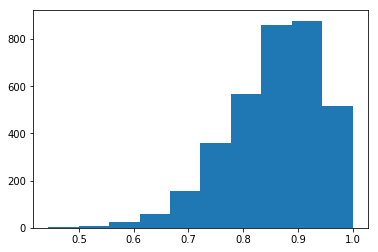

In [54]:
# summary statistics on the NDCG scores of the testset
print('Number of users of interest in the testset (at least 10 review ratings in the testset):', len(ndcg_scores))
print('Average NDCG score across all users of interest in the testset:', sum(ndcg_scores)/len(ndcg_scores))
print('Max and min NDCG scores for users of interest in the testset:', max(ndcg_scores), min(ndcg_scores))
print('25, 50, 75 and 90 percentiles of all the valid NDCG scores are:', np.percentile(ndcg_scores, [25, 50,75,90]))
plt.hist(ndcg_scores); # plot ndcg_score distribution

## 5.3 Compute & evaluate rankings based on cosine similarity from restaurant metadata-based features

Since the restaurant metafeature vectors and the user metafeature vectors all have a unit length of 1, linear_kernel from sklearn.metrics.pairwise is used instead of cosine_similarity to speed up the calculation.

In [43]:
# %%time
# # look at a particular user_id as an example

# user_id = '---1lKK3aKOuomHnwAkAow' # 11 review ratings available in the testset

# # compute user-restaurant similarity
# sim_matrix = linear_kernel(user_metafeature.loc[user_id].values.reshape(1, -1), rest_metafeature)
# sim_matrix = sim_matrix.flatten()
# sim_matrix = pd.Series(sim_matrix, index = rest_metafeature.index).sort_values(ascending=False)
# sim_matrix.name = 'similarity_score'

# # look at similarity score for reviews/ratings in the testset by the user of interest
# rec = pd.concat([sim_matrix, test[test.user_id == user_id].set_index('business_id').stars], axis=1, join='inner')
# print('Ranking by cosine similarity score:\n', rec)
# ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score@top10
# print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

In [44]:
# %%time
# # evaluate NDCG@top10 on the entire testset

# # only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
# rev_count_by_user = test.groupby('user_id').review_id.count()
# user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# ndcg_scores = []
# # compute NDCG score for each user in the testset
# for user_id in user_id_of_interest: 
    
#     # compute user-restaurant similarity matrix for the user of interest
#     sim_matrix = linear_kernel(user_metafeature.loc[user_id].values.reshape(1, -1), rest_metafeature)
#     sim_matrix = sim_matrix.flatten() # flatten the similarity matrix for a particular user into 1D array
#     sim_matrix = pd.Series(sim_matrix, index = rest_metafeature.index).sort_values(ascending=False)
#     sim_matrix.name = 'similarity_score'

#     # look at similarity score for reviews/ratings in the testset by the user of interest
#     rec = pd.concat([sim_matrix, test[test.user_id == user_id].set_index('business_id').stars], axis=1, join='inner')
#     assert len(rec) >= 10
#     ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score
#     ndcg_scores.append(ndcg)

#     if ndcg < 0.5: # inspect low ndcg score below 0.5
#         print('Ranking by cosine similarity score for user_id of {} is:\n {}'.format(user_id, rec.head(10)))

In [45]:
# print('Number of users of interest in the testset (at least 10 review ratings in the testset):', len(ndcg_scores))
# print('Average NDCG score across all users of interest in the testset:', sum(ndcg_scores)/len(ndcg_scores))
# print('Max and min NDCG scores for users of interest in the testset:', max(ndcg_scores), min(ndcg_scores))
# print('25, 50, 75 and 90 percentiles of all the valid NDCG scores are:', np.percentile(ndcg_scores, [25, 50,75,90]))
# plt.hist(ndcg_scores); # plot ndcg_score distribution

# 6. Implement content-based recommender module

# !!! current implementation uses the cosine similarity score based on the restaurant features extracted from reviews;
# !!![to be decided and added] how to combine the two similarity scores in the actual implementation, one similarity score based on features extracted from reviews, the other similarity score based on features extracted from restaurant metadata. 

In [46]:
import os.path
from sklearn.metrics.pairwise import linear_kernel

In [47]:
# extract a subset of reviews related to the restaurant business of our interest
review_s = review[review.business_id.isin(business.business_id.unique())]

In [48]:
class Recommender:
    
    def __init__(self, n=5, original_score=False):
        """initiate a Recommender object by passing the desired number of recommendations to make, the default number is 10.
        By default, the adjusted score will be used for ranking; To rank by the original average rating of the restaurant, pass original_score=True
        """
        self.n = n # number of recommendations to make, default is 5
        self.original_score = original_score # boolean indicating whether the original average rating or the adjusted score is used
        # initiate a list of column names to display in the recommendation results
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2','cuisine','style','review_count','stars','adjusted_score']
        
        # initiate the list of recommendations to be the entire catalog of the 'business' dataframe sorted by the score of interest
        if self.original_score:  # set sorting criteria to the originial star rating
            score = 'stars'
        else:  # set sorting criteria to the adjusted score
            score = 'adjusted_score'
        self.recomm = business.sort_values(score, ascending=False)
        
    def display_recommendation(self):
        """ Display the list of top n recommended restaurants
        """
        if len(self.recomm) == 0:
            print("Sorry, there is no matching recommendations.")
        elif self.n < len(self.recomm):  # display only the top n from the recommendation list
            print("Below is a list of the top {} recommended restaurants for you: ".format(self.n))
            print(self.recomm.iloc[:self.n][self.column_to_display])
        else:  # display all if # of recommendations is less than self.n
            print("Below is a list of the top {} recommended restaurants for you: ".format(len(self.recomm)))
            print(self.recomm[self.column_to_display])
 
    #------------------------------------------------------------
    # personalized content-based filtering recommender module
    def content(self, user_id=None):
        """Passing of user_id is required if personalized recommendation is desired.
        """
        
        self.user_id = user_id # user_id for personalized recommendation using collaborative filtering 
        if self.user_id is None:
            print("no user_id is provided!")
            return None
        if len(self.user_id) != 22:
            print("invalid user id!")
            return None
        if self.user_id not in review_s.user_id.unique(): # check if previous restaurant rating/review history is available for the user_id of interest
            print("sorry, no personal data available for this user_id yet!")
            return []
        
        # initiate every time the module is called
        self.recomm = business # start with the entire 'business' catalog
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2',\
                                  'cuisine','style','review_count','stars','adjusted_score'] # reset the columns to display
        if 'similarity_score' in self.recomm.columns:
            self.recomm.drop('similarity_score', axis=1, inplace=True) # delete the column of 'cosine_similarity' if already present
        
        # load the saved restaurant pca feature vectors
        with open('rest_pcafeature_allset.pkl', 'rb') as f:
            rest_pcafeature = pickle.load(f)
            
        # load the saved user pca feature vectors
        max_bytes = 2**31 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize('user_pcafeature_allset.pkl')
        with open('user_pcafeature_allset.pkl','rb') as f: 
            for _ in range(0, input_size, max_bytes):
                bytes_in += f.read(max_bytes)
            user_pcafeature = pickle.loads(bytes_in)
        
        # predict personalized cosine similarity scores for the user_id of interest
        sim_matrix = linear_kernel(user_pcafeature.loc[user_id].values.reshape(1, -1), rest_pcafeature)
        sim_matrix = sim_matrix.flatten()
        sim_matrix = pd.Series(sim_matrix, index = rest_pcafeature.index)
        sim_matrix.name = 'similarity_score'
        
        # pairing the computed cosine similarity score with the business_id by matching the corresponding matrix indices of the business_id
        self.recomm = pd.concat([sim_matrix, self.recomm.set_index('business_id')], axis=1, join='inner').reset_index()
        
        # filter to unrated business_id only by the user_id of interest if a personal history is available      
        busi_rated = review_s[review_s.user_id == self.user_id].business_id.unique()
        self.recomm = self.recomm[~self.recomm.business_id.isin(busi_rated)]
               
        # sort the recommendation by the cosine similarity score in descending order
        self.recomm = self.recomm.sort_values('similarity_score', ascending=False).reset_index(drop=True)
           
        # add 'similarity_score' to the list of columns to display
        self.column_to_display.insert(0, 'similarity_score') 
        
        # display the list of top n recommendations
        self.display_recommendation()
        
        return self.recomm

In [56]:
%%time

# load the saved restaurant pca feature vectors
with open('rest_pcafeature_allset.pkl', 'rb') as f:
    rest_pcafeature = pickle.load(f)
            
# load the saved user pca feature vectors
max_bytes = 2**31 - 1
bytes_in = bytearray(0)
input_size = os.path.getsize('user_pcafeature_allset.pkl')
with open('user_pcafeature_allset.pkl','rb') as f: 
    for _ in range(0, input_size, max_bytes):
        bytes_in += f.read(max_bytes)
    user_pcafeature = pickle.loads(bytes_in)

CPU times: user 2.84 s, sys: 9.27 s, total: 12.1 s
Wall time: 19.3 s


Note: the time needed to load the restaurant and user feature vectors is around 20 seconds.

### testing of the personalized content-based recommender module

In [50]:
%%time

# initiate a Recommender object
con = Recommender(n=10)

# test0: display only (same as no keywords)
print("------\nresult from test0 (display only): ")
con.display_recommendation()

# test1: no user id input
print("------\nresult from test1 (no user id input): ")
con.content();

# test 2: invalid user id input
print("------\nresult from test2 (invalid user id input): ")
con.content(user_id='928402');

------
result from test0 (display only): 
Below is a list of the top 10 recommended restaurants for you: 
      state             city                                  name  \
7464     AZ          Phoenix                       Little Miss BBQ   
31910    NV        Las Vegas                          Brew Tea Bar   
45401    NV        Las Vegas                            Gelatology   
7784     NV  North Las Vegas                          Poke Express   
28162    NV        Las Vegas                    Meráki Greek Grill   
2684     AZ             Mesa                        Worth Takeaway   
14567    NV        Las Vegas                Free Vegas Club Passes   
11521    NV        Las Vegas  Paranormal - Mind Reading Magic Show   
30972    NV        Las Vegas           Desert Wind Coffee Roasters   
46284    NV        Henderson                                HUMMUS   

                            address  attributes.RestaurantsPriceRange2  \
7464           4301 E University Dr              

In [51]:
%%time

# test 3: valid user id (no user data)
print("------\nresult from test3 (valid user id --- no user review data): ")
con.content(user_id='-NzChtoNOw706kps82x0Kg');

------
result from test3 (valid user id --- no user review data): 
sorry, no personal data available for this user_id yet!
CPU times: user 390 ms, sys: 290 ms, total: 681 ms
Wall time: 924 ms


In [52]:
%%time

# test 4: valid user id (user has only one review)
print("------\nresult from test4 (valid user id --- user has only one review): ")
con.content(user_id='---89pEy_h9PvHwcHNbpyg');

------
result from test4 (valid user id --- user has only one review): 
Below is a list of the top 10 recommended restaurants for you: 
   similarity_score state       city                               name  \
0          0.920511    NV  Henderson      The Bar At Bermuda & St. Rose   
1          0.913473    NV  Las Vegas  The Bar @ Las Vegas Blvd & Wigwam   
2          0.912803    NV  Las Vegas      The Bar @ Tropicana & Durango   
3          0.859365    NV  Las Vegas            The Bar @Trails Village   
4          0.848265    NV  Las Vegas              Distill - A Local Bar   
5          0.847307    NV  Las Vegas              Distill - A Local Bar   
6          0.841570    NV  Henderson                    Remedy's Tavern   
7          0.814201    NV  Las Vegas                 Sunrise Casablanca   
8          0.813073    NV  Las Vegas                   Aces Bar & Grill   
9          0.803431    NV  Las Vegas                Cactus Jacks Saloon   

                          address  att

As shown, the total time to return the recommendation is around 25 seconds, but the time needed to load the feature vectors is 20 seconds by itself. Therefore, to speed up the recommender's response time, an alternative way is to load in the restaurant and user feature vectors when initializing the recommender object (under the \__init\__ method). 

As shown, the personalized recommendation features mid-price range bars of high ratings near Las Vegas, these are very personalized recommendations based on the user's only review of a 4-star nightlife bars in the mid-price range located in Las Vegas, and the user gives the bar a 5-star review with strong positive words, a clear indication of his/her preference.

In [53]:
%%time

# test 5: valid user id (user has over 100 reviews)
print("------\nresult from test5 (valid user id --- user has over 100 reviews): ")
con.content(user_id='Ox89nMY8HpT0vxfKGqDPdA');

------
result from test5 (valid user id --- user has over 100 reviews): 
Below is a list of the top 10 recommended restaurants for you: 
   similarity_score state       city                          name  \
0          0.662795    AZ       Mesa                  Modern Grove   
1          0.656317    AZ    Gilbert              Joe's Farm Grill   
2          0.624906    AZ    Phoenix                           FEZ   
3          0.621353    AZ    Phoenix        Maizie's Cafe & Bistro   
4          0.613937    AZ       Mesa                  Orchard Eats   
5          0.606274    AZ   Surprise               New York Flavor   
6          0.598196    AZ    Phoenix                 Modern  Grove   
7          0.589970    NV  Las Vegas            Hunt & Gather Cafe   
8          0.583544    AZ    Phoenix                 Welcome Diner   
9          0.575226    AZ    Phoenix  Wally's American Pub N Grill   

                       address  attributes.RestaurantsPriceRange2  \
0     1958 E Brown Rd, 

As shown, the personalized recommendation list features popular restaurants (over 100 reviews) in the low-to-mid price range, featuring american style cuisines (pizza, burger), located in Arizona. These are very personalized recommendations based on the user's history of 120 restaurant reviews.